In [85]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas_datareader as data
import datetime
from datetime import time

In [86]:
# Choosing a period which we want to analyze for training and validating
start = datetime.datetime(2000, 1, 1)
end = datetime.date.today()

# Data from Yahoo finanse
df = data.DataReader('XOM', 'yahoo', start, end)


In [87]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,40.37500,38.93750,39.75000,39.15625,13458200.0,19.472006
2000-01-04,39.09375,38.25000,38.68750,38.40625,14510800.0,19.099047
2000-01-05,40.87500,38.90625,39.00000,40.50000,17485000.0,20.140251
2000-01-06,42.90625,40.09375,40.31250,42.59375,19461600.0,21.181450
2000-01-07,43.12500,42.00000,42.96875,42.46875,16603800.0,21.119289


In [88]:
#Separate dates for future plotting
df =  df[['Open', 'High', 'Low', 'Close', 'Adj Close']].reset_index()
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(5)) #Check last few dates. 

5645   2022-06-09
5646   2022-06-10
5647   2022-06-13
5648   2022-06-14
5649   2022-06-15
Name: Date, dtype: datetime64[ns]


In [89]:
#Variables for training
cols = list(df)[1:6]

#Date and volume columns are not used in training. 
print(cols)

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [90]:
# New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

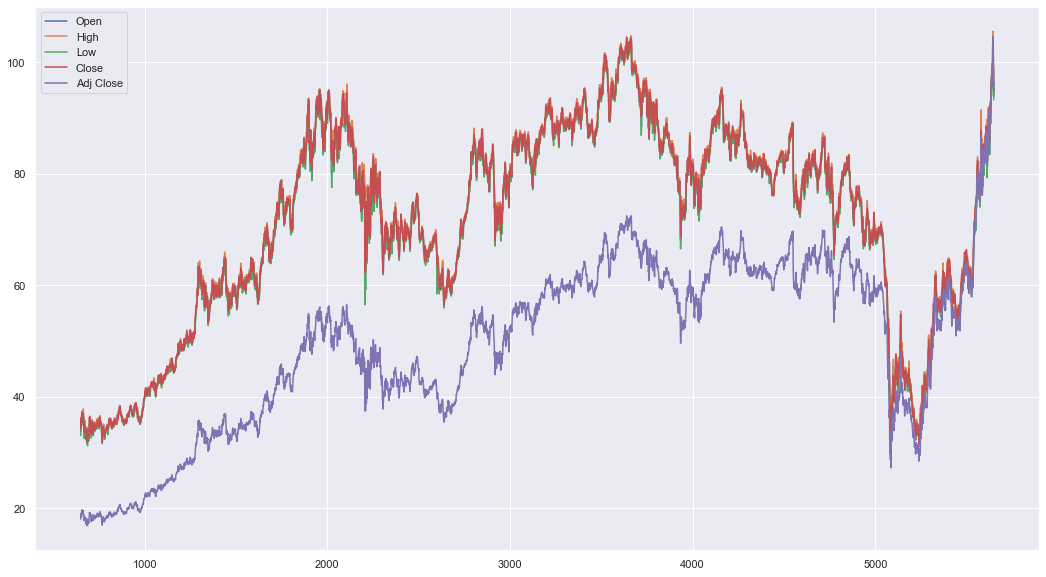

In [91]:
df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()
sns.set(rc={'figure.figsize':(18,10)})

In [92]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized.
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [93]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 30 (past days data used for training). 

#Empty lists to be populated using formatted training data.
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 30  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])


In [94]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (5620, 30, 5).
trainY shape == (5620, 1).


In [95]:
# We can only predict a single day after our training, the day after where our data ends
# To predict more days in future, we need all the 5 variables which we do not have. 
# We need to predict all variables if we want to do that. 

# define the Autoencoder model

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 30, 128)           68608     
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


In [96]:
# fit the model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
317/317 [==============================] - 13s 33ms/step - loss: 0.0476 - val_loss: 0.0165
Epoch 2/10
317/317 [==============================] - 12s 38ms/step - loss: 0.0210 - val_loss: 0.0290
Epoch 3/10
317/317 [==============================] - 13s 41ms/step - loss: 0.0200 - val_loss: 0.0783
Epoch 4/10
317/317 [==============================] - 14s 43ms/step - loss: 0.0179 - val_loss: 0.0149
Epoch 5/10
317/317 [==============================] - 12s 38ms/step - loss: 0.0171 - val_loss: 0.0263
Epoch 6/10
317/317 [==============================] - 12s 39ms/step - loss: 0.0156 - val_loss: 0.0093
Epoch 7/10
317/317 [==============================] - 11s 36ms/step - loss: 0.0167 - val_loss: 0.0106
Epoch 8/10
317/317 [==============================] - 11s 35ms/step - loss: 0.0155 - val_loss: 0.0101
Epoch 9/10
317/317 [==============================] - 11s 36ms/step - loss: 0.0148 - val_loss: 0.0061
Epoch 10/10
317/317 [==============================] - 11s 35ms/step - loss: 0.015

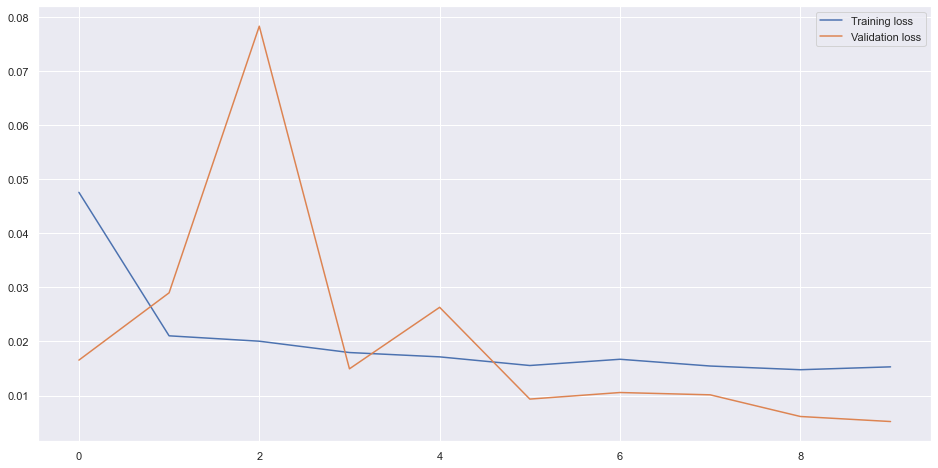

In [97]:
# Plot model history
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

# Predicting...

In [98]:

#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())


# We can only predict one day in future as our model needs 5 variables
# as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction


[Timestamp('2022-05-24 00:00:00', freq='C'), Timestamp('2022-05-25 00:00:00', freq='C'), Timestamp('2022-05-26 00:00:00', freq='C'), Timestamp('2022-05-27 00:00:00', freq='C'), Timestamp('2022-05-31 00:00:00', freq='C'), Timestamp('2022-06-01 00:00:00', freq='C'), Timestamp('2022-06-02 00:00:00', freq='C'), Timestamp('2022-06-03 00:00:00', freq='C'), Timestamp('2022-06-06 00:00:00', freq='C'), Timestamp('2022-06-07 00:00:00', freq='C'), Timestamp('2022-06-08 00:00:00', freq='C'), Timestamp('2022-06-09 00:00:00', freq='C'), Timestamp('2022-06-10 00:00:00', freq='C'), Timestamp('2022-06-13 00:00:00', freq='C'), Timestamp('2022-06-14 00:00:00', freq='C')]
1/1 [==============================] - 0s 358ms/step


In [99]:
# Perform inverse transformation to rescale back to original range
# We used 5 variables for transform, the inverse expects same dimensions
# Copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [100]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

original = df[['Date', 'Close']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2022-6-1']

c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Close'>

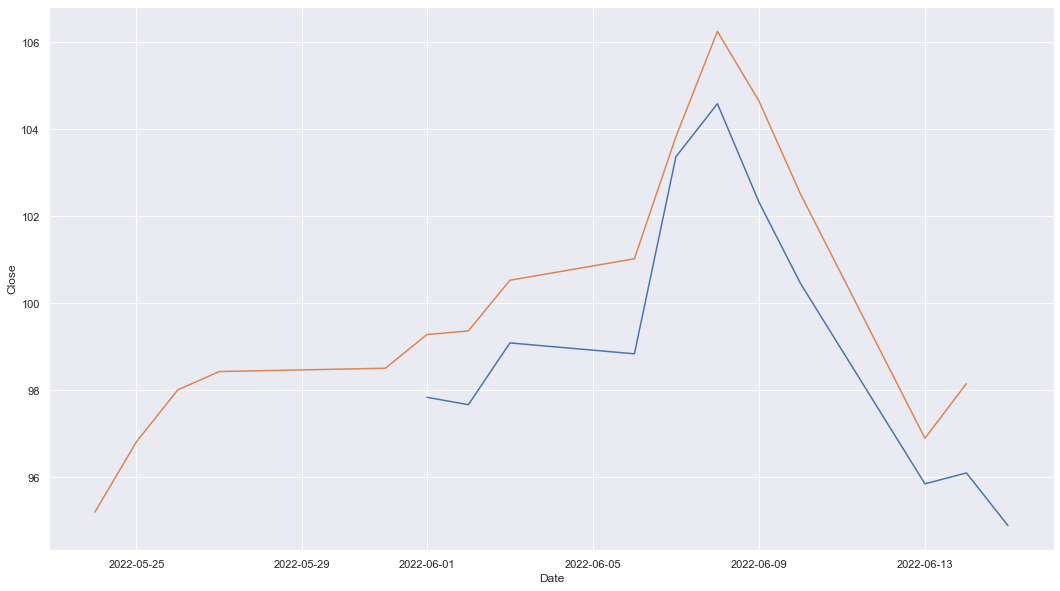

In [113]:
sns.lineplot(original['Date'], original['Close'])
sns.lineplot(df_forecast['Date'], df_forecast['Close'])